# Visualizing Chromatin State Trajectories with JointDb and Multi-Omic Heatmaps

This notebook demonstrates how to visualize chromatin state trajectories across multiple T cell samples using a `JointDb` database created with `jointly-hic`.

We use the results of a joint embedding and trajectory analysis to organize genomic bins by inferred trajectory-like structure, then overlay epigenomic signals and compartment-level Hi-C structure using a multi-panel heatmap.

## What You'll Learn

- How to load Hi-C embeddings and ChIP-seq signal data from a `JointDb`
- How to align and merge data across samples and assays
- How to sort genomic bins by trajectory-defined clusters (e.g., `kmeans_8`)
- How to scale and coarsen data for clean heatmap visualization
- How to configure and render a multi-track heatmap showing:
  - Cluster identity (`IPG`, `kmeans_8`)
  - Principal component scores (PC1–PC5)
  - ChIP-seq signal (e.g., H3K27ac, H3K9me3, CTCF)

## Inputs

- `t-cell-jointdb.h5`: The JointDb database (created via `jointly hdf5db`)
- `*_trajectories.pq`: Output of the `jointly trajectory` module (contains cluster assignments)
- BigWig tracks described in the YAML metadata (loaded via JointDb)
- Hi-C embeddings and sample metadata annotated per bin

## Outputs

- `trajectory-heatmap-data.pq`: Final per-bin dataset with all embeddings and tracks
- `trajectory-heatmap.pdf`: A clustered, multi-row heatmap showing:
  - Interaction profile group (IPG) assignment (`leiden_0_3_n500`)
  - Hi-C Embedding dynamics (PC1–PC5)
  - Chromatin trajectory clusters (`kmeans_8`)
  - Per-sample ChIP-seq signal overlays
- `ordered-trajectory-heatmap.pdf`: The heatmap with clustered ordered by mean PC-1 across samples

## Use Cases

- Comparative chromatin analysis across conditions or cell types
- Visual discovery of patterns in PCA or UMAP embeddings
- Integration of 3D genome structure with regulatory element activity
- Chromatin state trajectory inference and visualization

These figures provides an interpretable, high-level view of how 3D genome compartments and regulatory signals co-evolve along trajectory-like axes inferred from Hi-C data.

In [1]:
import colorsys
from collections.abc import Callable
from functools import reduce
from typing import Callable, List, Optional, Union

import bioframe
import cooler
import cooltools
import datashader as ds
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cooltools.lib import numutils, runlength
from jointly_hic.hdf5db.hdf5db import JointDb
from sklearn.decomposition import PCA

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"

In [2]:
# Define heatmap plotting functions
DEFAULT_CONFIG = {"type": "scalar", "options": {}}


def colorlist_to_rgba(clist):
    return np.array([mpl.colors.to_rgba(c) for c in clist]).reshape(1, -1, 4)


def get_track_height_ratios(layout, trackconfs):
    height_ratios = []
    for block in layout.values():
        for name in block:
            conf = trackconfs.get(name, DEFAULT_CONFIG.copy())
            if "multivec" in conf:
                height_ratios.append(len(conf["multivec"]) * conf.get("height", 1))
            else:
                height_ratios.append(conf.get("height", 1))
    return height_ratios


def prepare_track(name, conf, bins, idx, coarse_factor):
    # Make the data matrix (n_tracks, n_loci)
    if "multivec" in conf:
        X = np.concatenate([[bins[col].values] for col in conf["multivec"]], axis=0)
        names = conf["multivec"]
    else:
        X = np.array([bins[name].values])
        names = [name]

    # Sort the tracks by the cluster labels and sub-orderings
    X = X[:, idx]

    # Convert to imshow-compatible input and options
    imshow_kwargs = conf["options"].copy()
    match conf["type"]:
        case "scalar":
            imshow_kwargs.setdefault("cmap", "Reds")
            imshow_kwargs.setdefault("vmin", 0)
            Y = numutils.coarsen(np.nanmean, X, {1: coarse_factor}, trim_excess=True)
        case "divergent":
            imshow_kwargs.setdefault("cmap", "RdBu_r")
            if "vmax" not in imshow_kwargs:
                vopt = np.percentile(np.max(np.abs(X)), 98)
                imshow_kwargs["vmin"] = -vopt
                imshow_kwargs["vmax"] = vopt
            Y = numutils.coarsen(np.nanmean, X, {1: coarse_factor}, trim_excess=True)
        case "category" | "categorical":
            if "color_dict" not in imshow_kwargs:
                categories = set(X.ravel().tolist())
                pal = sns.color_palette("tab20", n_colors=len(categories))
                color_dict = {cat: pal[i] for i, cat in enumerate(categories)}
            else:
                color_dict = imshow_kwargs.pop("color_dict")
            Y = np.concatenate(
                [
                    colorlist_to_rgba([color_dict.get(x, "#000000") for x in row])
                    for row in X
                ],
                axis=0,
            )
        case "colorlist":
            Y = np.concatenate([colorlist_to_rgba(row) for row in X], axis=0)
        case _:
            raise ValueError(f"Unknown track type for '{name}': '{conf['type']}'")

    return names, Y, imshow_kwargs


def clustermap(
    bins: pd.DataFrame,
    group_by: str,
    sort_by: str | list[str],
    layout: dict[str, list[str]],
    trackconfs: dict[str, dict],
    coarse_factor: int = 32,
    figsize: tuple[int] = (24, 20),
    filename: Optional[str] = None,
) -> mpl.figure.Figure:
    """
    Render tracks of binned genomic data.

    Data are grouped by custom labels and a sorted by a custom ordering.

    Parameters
    ----------
    bins : pd.DataFrame
        A DataFrame with all required binned tracks.

    group_by : str
        The column name to group the bins by.

    sort_by : str | list[str]
        The column name(s) to sort the bins in each group by.

    layout : dict[str, list[str]]
        A dictionary with the layout of the tracks by name. Divided into
        "blocks", which aren't currently meaningful. Use dummy block names.
        ``{block_name: [track_name, ...], ...}``.

    trackconfs : dict[str, dict]
        A dictionary with the configuration dictionary of each track.
        See notes for the structure of the configuration dictionary.
        ``{track_name: track_config, ...}``.

    coarse_factor : int
        The factor by which to coarsen scalar data.

    figsize : tuple[int]
        The figure size.

    Returns
    -------
    mpl.figure.Figure
        The rendered figure.

    Notes
    -----
    The track configuration dictionary has the following structure:

    - ``type`` : str
        The type of the track. One of ``'scalar'``, ``'divergent'``,
        ``'category'``, ``'categorical'``, or ``'colorlist'``.
    - ``multivec`` : list[str], optional
        The list of columns to concatenate for a multivec track.
        If not provided, the track will be a single vector track.
    - ``height`` : int, optional
        The height of the track.
    - ``options`` : dict
        A dictionary with additional options to pass to imshow/matshow.
        Use this to set the colormap, vmin, vmax, etc.
        For categorical/colorlist data, you can also pass a ``color_dict`` here.
    """
    labels = bins[group_by].values
    n_loci = labels.shape[0]

    # Sort bins by cluster label, then by user-specified fields
    if isinstance(sort_by, str):
        sort_by = [sort_by]
    sorting_cols = [labels] + [bins[col].values for col in sort_by]
    idx = np.lexsort(sorting_cols[::-1])

    # Get the partition of the sorted labels
    partition = [run[0] for run in runlength.iterruns(labels[idx])]

    # Set up the figure
    lo, hi = 0, n_loci  # partition[-1]
    n_tracks = sum(len(block) for block in layout.values())
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(
        nrows=n_tracks,
        ncols=1,
        height_ratios=get_track_height_ratios(layout, trackconfs),
        hspace=0,
    )
    ax0 = plt.subplot(gs[0])

    # Render the tracks
    i = 0
    for _, block in layout.items():
        for name in block:
            ax = plt.subplot(gs[i], sharex=ax0 if i > 0 else None)

            # Get the track configuration
            conf = trackconfs.get(name, DEFAULT_CONFIG.copy())

            # Prepare the track data
            names, data, kwargs = prepare_track(name, conf, bins, idx, coarse_factor)
            nrows = data.shape[0]

            # Plot the track
            ax.matshow(
                data,
                rasterized=True,
                extent=[-0.5, n_loci - 0.5, -0.5, nrows - 0.5],
                origin="lower",
                **kwargs,
            )
            ax.xaxis.set_visible(False)
            ax.set_aspect("auto")
            ax.set_xlim(lo - 0.5, hi - 0.5)
            ax.set_ylim(nrows - 0.5, -0.5)
            ax.set_yticks(np.arange(nrows))
            ax.set_yticklabels(names)
            plt.vlines(partition, -0.5, nrows - 0.5, lw=1, color="k")
            i += 1

    if filename is not None:
        plt.savefig(filename)

    return fig

In [3]:
# Define data loading function
def load_biosamples_assays(
    db,
    accessions: List[str],
    embeddings: List[str],
    assays: List[str],
    drop_bad_bins: bool = True,
    scaler: Optional[Callable] = None,
) -> pd.DataFrame:
    """
    Load embeddings for all given accessions, then for each accession+assay,
    load signals via db.get_tracks(), pivot, and produce a unified wide DataFrame.

    Final column order:
      1) chrom, start, end, bin_name, good_bin
      2) {accession}.{embedding}, for each embedding in 'embeddings' (outer loop)
         and for each accession in 'accessions' (inner loop).
      3) {accession}.{assay}, for each assay in 'assays' (outer loop)
         and for each accession in 'accessions' (inner loop).

    Returns
    -------
    pd.DataFrame
        A wide DataFrame indexed by bin_name (after final .reset_index(drop=False)),
        with columns in the order described above.
    List
        List of embedding_columns, the column names of {biosample}.{embedding}
    List
        List of assay_columns, the column names of {biosample}.{assay}
    """

    # Filter experiment metadata for given biosamples
    meta = db.experiment_metadata
    selected_meta = meta[meta["accession"].isin(accessions)]
    if selected_meta.empty:
        raise ValueError(
            f"No experiment_metadata found for the biosamples: {biosamples}"
        )

    # Collect all relevant accessions
    relevant_accessions = list(selected_meta["accession"])

    # Load embeddings for these accessions
    emb_df = db.get_embeddings(
        embeddings, accessions=relevant_accessions, drop_bad_bins=drop_bad_bins
    )

    # Pivot so each row is bin_name, columns => "accession.embedding"
    emb_df = emb_df.set_index(["bin_name", "accession"])[embeddings].unstack(
        "accession"
    )
    # We want (embedding, accession) as the final order on columns:
    emb_df = emb_df.swaplevel(axis=1).sort_index(axis=1)

    # Flatten columns => "embedding.accession"
    new_cols = [f"{emb}.{acc}" for (acc, emb) in emb_df.columns.to_flat_index()]
    emb_df.columns = new_cols

    # Bring bin_name back as a column
    emb_df.reset_index(inplace=True)

    # Build final_df from emb_df, then add track data columns
    final_df = emb_df.set_index("bin_name")  # index by bin_name for easy alignment
    have_coords = False  # track if we've included chrom, start, end, good_bin
    track_df_list = []

    for assay in assays:
        # Get track accessions for the assay
        track_list = list(
            db.track_metadata.loc[db.track_metadata.assay == assay, "accession"]
        )

        track_df = db.get_tracks(track_list, drop_bad_bins=drop_bad_bins)
        # track_df columns: [chrom, start, end, good_bin, bin_name, *track_list]

        if track_df.empty:
            print(f"No data found for {assay} in get_tracks()")
            continue

        # Rename track_col => f"{assay}.{accession}"
        new_cols = [f"{assay}.{ax}" for ax in track_list]
        track_df.rename(
            columns={tr: col for tr, col in zip(track_list, new_cols)}, inplace=True
        )

        # Scale by scaler if provided
        if scaler is not None:
            for col in new_cols:
                track_df[col] = scaler(track_df[col])

        # We can keep coordinates once (chrom, start, end, good_bin).
        cols_to_keep = ["bin_name", *new_cols]
        if not have_coords:
            cols_to_keep = ["chrom", "start", "end", "good_bin", *cols_to_keep]
            have_coords = True

        # Subset & set index
        track_df = track_df[cols_to_keep].copy()
        track_df.set_index("bin_name", inplace=True)

        # Append
        track_df_list.append(track_df)

    # Concat side-by-side
    final_df = pd.concat([final_df, *track_df_list], axis=1)

    # Re-order columns
    final_df.reset_index(inplace=True)

    # We'll define the final order:
    #  1) chrom, start, end, bin_name, good_bin
    #  2) for e in embeddings:
    #       for x in relevant_accessions => f"{e}.{x}"
    #  3) for a in assays:
    #       for x in relevant_accessions => f"{a}.{x}"

    col_order = []

    # 1) coordinates
    coord_candidates = ["chrom", "start", "end", "bin_name", "good_bin"]
    for cc in coord_candidates:
        if cc in final_df.columns:
            col_order.append(cc)

    # 2) embeddings in the specified order
    embedding_columns = []
    for e in embeddings:
        for x in db.experiment_metadata.accession:
            candidate = f"{e}.{x}"
            if candidate in final_df.columns:
                col_order.append(candidate)
                embedding_columns.append(candidate)

    # 3) signals in the order of assays, then relevant_accessions => f"{x}.{a}"
    assay_columns = []
    for a in assays:
        for x in db.track_metadata.accession:
            candidate = f"{a}.{x}"
            if candidate in final_df.columns:
                col_order.append(candidate)
                assay_columns.append(candidate)

    # 4) Reorder and keep all columns (if not in reorder list)
    existing_cols = final_df.columns.tolist()

    # Check for leftover columns
    leftover_cols = [c for c in existing_cols if c not in col_order]
    if len(leftover_cols) > 0:
        print(f"Leftover columns: {leftover_cols}")

    # build final
    ordered_cols = col_order + leftover_cols
    final_df = final_df.reindex(columns=ordered_cols)

    return final_df, embedding_columns, assay_columns

In [4]:
# Connect to JointDb
JOINTDB_FILE = "./data/t-cell-jointdb.h5"
db = JointDb(JOINTDB_FILE)
db

JointDb(file='./data/t-cell-jointdb.h5', bins=38614, experiments=10, tracks=68)

In [5]:
# Get list of accessions
accessions = db.experiment_metadata.accession.tolist()
accessions

['ENCFF009ONH',
 'ENCFF044TCQ',
 'ENCFF355VJW',
 'ENCFF442IGJ',
 'ENCFF493SFI',
 'ENCFF520GFL',
 'ENCFF571GTF',
 'ENCFF958DWQ',
 'ENCFF962EDB',
 'ENCFF980NXK']

In [6]:
# Get list of assays
assays = db.track_metadata["assay"].unique().tolist()
assays

['H3K9me3', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K36me3', 'H3K27ac', 'H3K9ac']

In [7]:
# Use bioframe to fetch chromsizes
assembly = "hg38"
chromsizes = bioframe.fetch_chromsizes(assembly)
chromosomes = list(chromsizes[:"chr22"].index)


def bedsort(df, chromsizes=chromsizes):
    df = df.copy()
    df["chrom"] = pd.Categorical(df["chrom"], chromsizes.keys(), ordered=True)
    return df.sort_values(["chrom", "start", "end"]).reset_index(drop=True)

In [8]:
# Load embedding data
embeddings = [f"PCA{i+1}" for i in range(5)]


def scale_signal(x) -> pd.Series:
    # Clip outliers and Z-score scale
    return x.clip(lower=x.quantile(0.05), upper=x.quantile(0.95)).pipe(
        lambda s: (s - s.mean()) / s.std()
    )


# Load this data
final_df, embedding_columns, assay_columns = load_biosamples_assays(
    db,
    accessions=accessions,
    embeddings=embeddings + ["leiden_0_3_n500"],
    assays=assays,
    drop_bad_bins=True,
    scaler=scale_signal,
)

# Convert clustering columns to int
for col in final_df.columns:
    if col.startswith("leiden_0_3_n500"):
        final_df[col] = final_df[col].astype(int)

# Identify the columns to sort row-wise
cols_to_sort = [col for col in final_df.columns if col.startswith("leiden_0_3_n500")]
final_df.loc[:, cols_to_sort] = np.sort(final_df.loc[:, cols_to_sort].values, axis=1)

# Load trajectory clusters
trajectories = pd.read_parquet(
    "./data/t-cell-demo-output_PCA-32_80000bp_hg38_trajectories.pq"
).dropna()
trajectories

# Merge kmeans_8
final_df = final_df.merge(trajectories[["chrom", "start", "end", "kmeans_8"]])

# Load bin information
bins = db.bins
bins = bins[bins.chrom.isin(chromosomes)]
final_df = final_df.merge(bins[["chrom", "start", "end"]])

# Save table to file
final_df.to_parquet("./data/trajectory-heatmap-data.pq")
final_df

,chrom,start,end,bin_name,good_bin,PCA1.ENCFF009ONH,PCA1.ENCFF044TCQ,PCA1.ENCFF355VJW,PCA1.ENCFF442IGJ,PCA1.ENCFF493SFI,...,H3K27ac.ENCFF373LYP,H3K27ac.ENCFF495UDL,H3K27ac.ENCFF599VAD,H3K27ac.ENCFF653TLI,H3K27ac.ENCFF694IFY,H3K27ac.ENCFF892JDN,H3K27ac.ENCFF902LSI,H3K27ac.ENCFF966FLQ,H3K9ac.ENCFF264QTV,kmeans_8
0,chr10,10000000,10080000,chr10:10000000-10080000,True,-0.004122,-0.002284,-0.004639,-0.003044,-0.004251,...,-0.420936,-0.843864,-0.425689,-0.716294,-0.643226,-0.580946,-0.636950,-0.512192,-0.742700,6.0
1,chr10,100000000,100080000,chr10:100000000-100080000,True,0.003386,0.003146,0.003932,0.002605,0.003843,...,-0.429282,-0.414290,-0.505227,-0.303710,-0.301767,-0.357600,-0.262537,-0.452156,0.553656,5.0
2,chr10,100080000,100160000,chr10:100080000-100160000,True,0.003267,0.003060,0.003526,0.002624,0.004558,...,-0.280504,-0.709621,-0.592850,-0.468347,-0.187881,-0.576841,-0.371449,-0.092289,-0.317577,5.0
3,chr10,100160000,100240000,chr10:100160000-100240000,True,0.005786,0.005701,0.007164,0.005625,0.006438,...,2.156974,2.858552,2.593443,2.722916,2.620026,1.783965,2.045043,1.615387,2.247073,5.0
4,chr10,100240000,100320000,chr10:100240000-100320000,True,0.006123,0.006264,0.007296,0.006139,0.006790,...,2.187852,1.753061,1.915765,1.472054,1.963146,1.028119,1.867392,1.649425,1.465068,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31996,chr9,99600000,99680000,chr9:99600000-99680000,True,-0.000198,-0.000659,-0.000075,-0.001321,0.000870,...,-0.422473,-0.632415,-0.469515,-0.612385,-0.485328,-0.481521,-0.493333,-0.522193,0.360920,7.0
31997,chr9,99680000,99760000,chr9:99680000-99760000,True,0.000895,0.000251,0.000268,-0.000497,0.001588,...,-0.391096,-0.008298,-0.150188,-0.349547,-0.212738,-0.129367,-0.196733,0.019077,0.359459,7.0
31998,chr9,99760000,99840000,chr9:99760000-99840000,True,0.003028,0.002733,0.004711,0.002506,0.003371,...,1.581448,2.535393,2.610098,1.577794,2.239843,1.014846,0.874534,1.226747,2.247073,0.0
31999,chr9,99840000,99920000,chr9:99840000-99920000,True,0.002962,0.002489,0.003235,0.002530,0.002820,...,1.875339,1.677583,2.880261,0.901887,1.099990,0.820341,1.009192,1.221086,1.407810,0.0


In [9]:
km10_palette = {
    0: "#1f77b4",  # medium blue
    1: "#aec7e8",  # light blue
    2: "#ff7f0e",  # orange
    3: "#ffbb78",  # light orange / peach
    4: "#2ca02c",  # green
    5: "#98df8a",  # light green
    6: "#d62728",  # red
    7: "#ff9896",  # light red / salmon
    8: "#9467bd",  # purple
    9: "#c5b0d5",  # lavender
}

In [10]:
# Aesthetic settings
trackconfs = {
    "chrom": {"type": "category"},
    "cluster": {"type": "category", "options": {"color_dict": km10_palette}},
    "IPG": {
        "multivec": [
            col for col in embedding_columns if col.startswith("leiden_0_3_n500")
        ],
        "height": 0.5,
        "type": "category",
        "options": {"color_dict": km10_palette},
    },
    **{
        f"{embedding}": {
            "multivec": [col for col in embedding_columns if col.startswith(embedding)],
            "height": 0.5,
            "type": "divergent",
            "options": {"cmap": "RdBu_r"},  # , "vmin": -2, "vmax": 2},
        }
        for embedding in embeddings
    },
    **{
        f"{assay}": {
            "multivec": [col for col in assay_columns if col.startswith(assay)],
            "height": 0.5,
            "type": "divergent",
            "options": {"cmap": "seismic"},  # "vmin": -2.0, "vmax": 2.0},
        }
        for assay in assays
    },
}

# What to actually plot
layout = {
    "group0": ["IPG"],
    "group1": [emb for emb in embeddings if emb.startswith("PCA")],
    "group2": [assay for assay in assays],
}

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 50 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 6

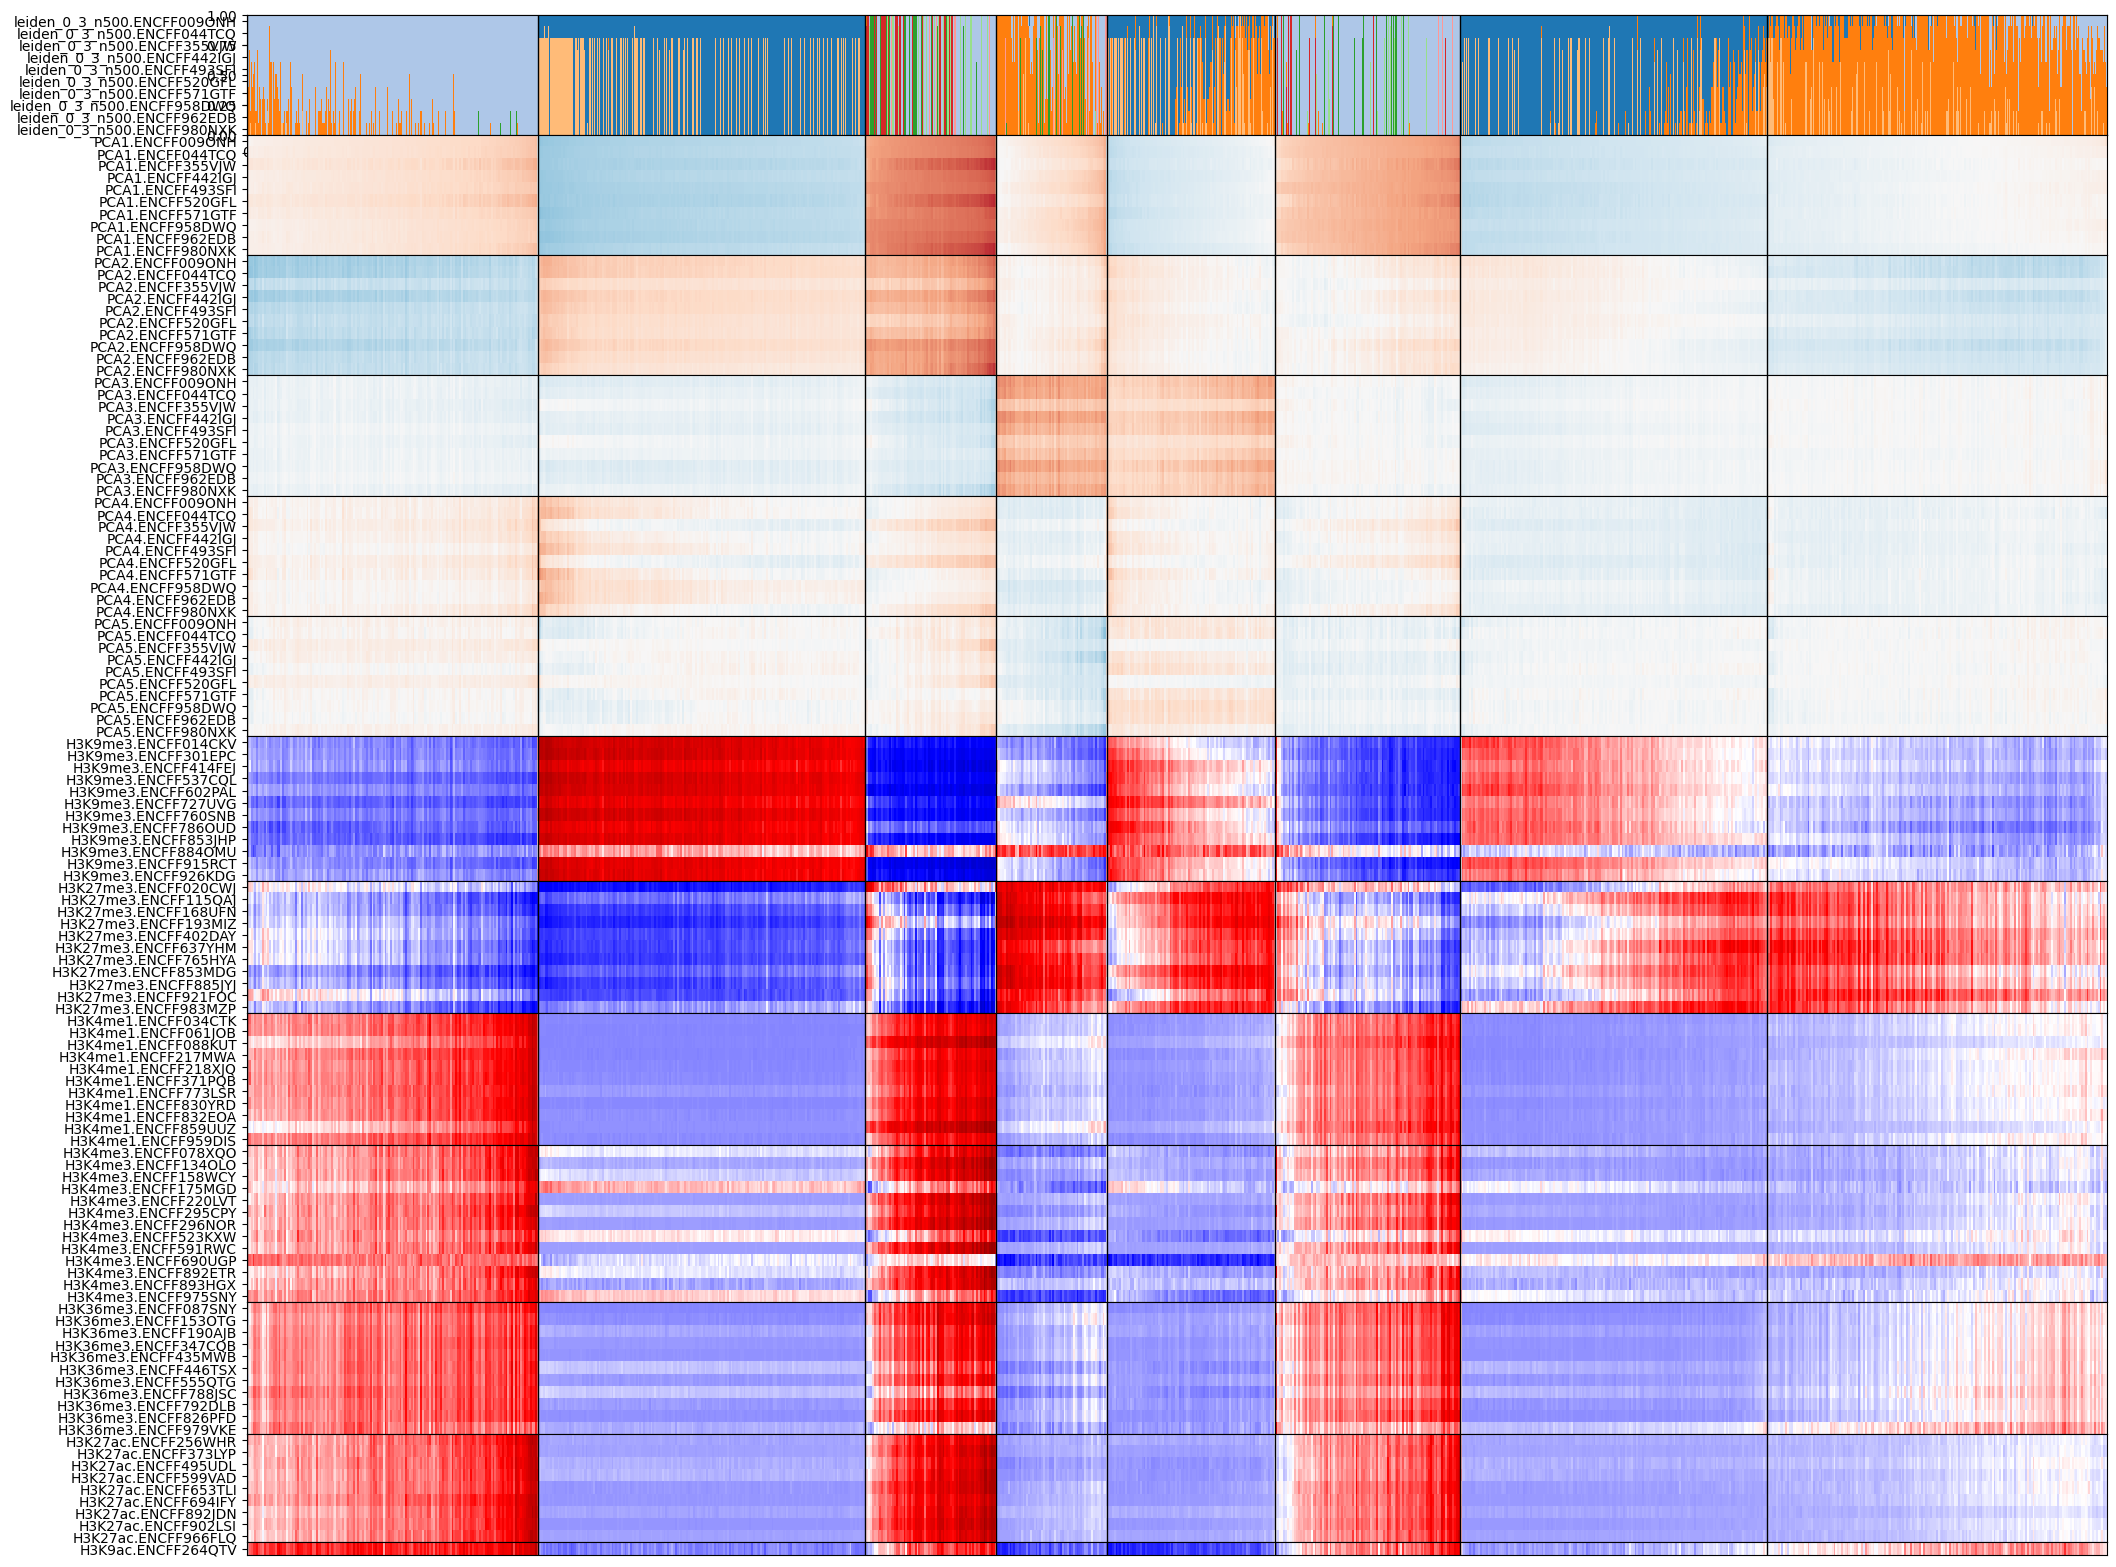

In [11]:
final_df["cluster"] = final_df["kmeans_8"].astype(int)

fig = clustermap(
    final_df,
    group_by="cluster",
    sort_by=["PCA1.ENCFF009ONH"],
    layout=layout,
    trackconfs=trackconfs,
    filename="trajectory-heatmap.pdf",
)

In [12]:
def parse_column(col: str):
    """
    Splits a column of the form 'PC1.SAMPLE1' or 'H3K27me3.SAMPLE1'
    into ('PC1', 'SAMPLE1') or ('H3K27me3', 'SAMPLE1'), etc.
    If your columns have a different pattern, adjust parsing as needed.
    """
    # We assume exactly one '.' dividing them:
    # 'embedding.accession' or 'assay.accession'
    left, right = col.split(".", 1)
    return left, right


def reorder_multivec_columns(col_list, accession_order):
    """
    Given a list of columns (e.g. ['PC1.SAMPLE2', 'PC1.SAMPLE1', 'PC2.SAMPLE2', ...])
    and a desired ordering of accessions, return a new list of columns sorted so that
    columns for accession_i come in the order defined by `accession_order`.

    Each column name is assumed to be 'something.accession'.
    """
    # We create a mapping accession -> rank
    accession_rank = {acc: i for i, acc in enumerate(accession_order)}

    def sort_key(col):
        # parse out the accession
        left, acc = parse_column(col)
        return (accession_rank.get(acc, 999999), left)

    return sorted(col_list, key=sort_key)


def compute_accession_order_by_pca(
    final_df: pd.DataFrame, columns_of_interest: list
) -> list:
    """
    columns_of_interest = list of wide columns in final_df, e.g.
       ["PC1.SAMPLE1", "PC2.SAMPLE1", "PC1.SAMPLE2", "PC2.SAMPLE2", ...]

    1. Melt + parse out (embedding, accession)
    2. Pivot => row=accession, col=(bin_name + '.' + embedding) => cell=signal
    3. PCA => get PC1 for each accession
    4. Return list of accessions in descending order of PC1
    """
    # Identify ID vars to keep from final_df
    id_vars = ["bin_name"]  # or possibly also keep chrom, start, etc. if needed
    id_vars = [c for c in id_vars if c in final_df.columns]

    # Melt
    df_melt = final_df.melt(
        id_vars=id_vars,
        value_vars=columns_of_interest,
        var_name="feature_col",
        value_name="value",
    )
    # parse out embedding OR assay, as well as accession
    df_melt["feature"], df_melt["accession"] = zip(
        *df_melt["feature_col"].apply(parse_column)
    )

    # Create a pivot so that the row is accession, the columns are (bin_name + '.' + feature)
    df_melt["bin_feature"] = df_melt["bin_name"].astype(str) + "." + df_melt["feature"]

    df_pivot = df_melt.pivot(index="accession", columns="bin_feature", values="value")
    # We now have shape: [#accessions x (#bins * #distinct_features)]

    # Fill any missing with 0 or mean
    df_pivot = df_pivot.fillna(0)

    # Let’s do a quick mean-centering to avoid large scale differences
    X = df_pivot.values
    X_mean = X.mean(axis=0, keepdims=True)
    X_std = X.std(axis=0, keepdims=True) + 1e-9
    X_scaled = (X - X_mean) / X_std

    # Fit PCA
    pca = PCA(n_components=1)
    # shape => (n_accessions, 1)
    X_pca = pca.fit_transform(X_scaled)

    # We get PC1 for each accession => X_pca[:,0]
    pc1 = X_pca[:, 0]

    # Build a Series to pair PC1 values with accession
    pc1_series = pd.Series(pc1, index=df_pivot.index, name="PC1")

    # Sort descending
    pc1_series = pc1_series.sort_values(ascending=False)

    # Return the final accession order
    return pc1_series.index.tolist()


def reorder_trackconfs_by_pca(
    final_df: pd.DataFrame,
    embeddings: list,
    assays: list,
    embedding_columns: list,
    assay_columns: list,
    trackconfs: dict,
) -> dict:
    """
    1. Compute a single PCA across ALL embedding columns (PC1, PC2, ... for all accessions).
       -> accession order (descending PC1).
    2. Reorder the 'IPG' block + each embedding block in trackconfs accordingly.
    3. For each assay, compute a separate PCA -> accession order.
    4. Reorder each assay block in trackconfs accordingly.

    Returns a NEW trackconfs dict (does not mutate in-place).
    """
    # EMBEDDING PCA => one accession order for all embeddings
    # We want to use all embedding columns that look like {embedding}.{accession}.
    all_embedding_accession_order = compute_accession_order_by_pca(
        final_df=final_df, columns_of_interest=embedding_columns
    )

    # Reorder "IPG" block and each embedding block by that order
    new_trackconfs = {}
    for track_name, conf in trackconfs.items():
        # If this config has a "multivec" list, we might reorder it
        if isinstance(conf, dict) and "multivec" in conf:
            # Check if track_name is "IPG" or in embeddings
            if track_name == "IPG" or track_name in embeddings:
                # reorder
                old_list = conf["multivec"]
                new_list = reorder_multivec_columns(
                    old_list, all_embedding_accession_order
                )
                new_conf = {**conf, "multivec": new_list}
                new_trackconfs[track_name] = new_conf
            else:
                # leave as is
                new_trackconfs[track_name] = conf
        else:
            # pass through any non-multivec or non-dict entries
            new_trackconfs[track_name] = conf

    # For each assay, compute a PCA -> reorder that block
    for assay in assays:
        # gather columns that start with f"{assay}."
        assay_cols = [c for c in assay_columns if c.startswith(f"{assay}.")]
        if len(assay_cols) == 0:
            continue

        # PCA => get accession order
        assay_accession_order = compute_accession_order_by_pca(
            final_df=final_df, columns_of_interest=assay_cols
        )

        # reorder the track config block for that assay
        if assay in new_trackconfs and "multivec" in new_trackconfs[assay]:
            old_list = new_trackconfs[assay]["multivec"]
            new_list = reorder_multivec_columns(old_list, assay_accession_order)
            new_trackconfs[assay] = {**new_trackconfs[assay], "multivec": new_list}

    return new_trackconfs

In [13]:
# Produce a new track config with updated row ordering:
new_trackconfs = reorder_trackconfs_by_pca(
    final_df=final_df,
    embeddings=embeddings,
    assays=assays,
    embedding_columns=embedding_columns,
    assay_columns=assay_columns,
    trackconfs=trackconfs,
)

/home/reimonnt/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:591: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


In [14]:
# 1) Identify columns that match "PC1.{accession}"
pc1_cols = [c for c in final_df.columns if c.startswith("PCA1.")]

# 2) Group by cluster and compute the mean of all PC1 columns
#    final_df["cluster"] must already be set, e.g. from "final_df['cluster'] = final_df['kmeans_8'].astype(int)"
grouped_pc1 = final_df.groupby("cluster")[
    pc1_cols
].mean()  # shape => (#clusters x #PC1_columns)

# 3) For each cluster, compute a *single* mean across all PC1 columns
grouped_pc1["mean_pc1"] = grouped_pc1.mean(axis=1)

# 4) Sort clusters by that mean PC1 in descending order
sorted_clusters = grouped_pc1["mean_pc1"].sort_values(ascending=False)

# This is a Series whose index = cluster label, value = mean_pc1
# e.g. cluster -> mean_pc1
#  2  ->  0.314
#  5  ->  0.277
#  0  -> -0.010
#  1  -> -0.213
# etc.

# We can get a list of clusters in descending order:
cluster_order = sorted_clusters.index.tolist()
# e.g. [2, 5, 0, 1, 7, 3, 4, 6] for kmeans_8

# Optionally build a mapping: old_cluster -> new_rank
# e.g. cluster 2 is rank 0, cluster 5 is rank 1, etc.
cluster_to_rank = {c: i for i, c in enumerate(cluster_order)}

print("Cluster order by descending mean PC1:", cluster_order)
print("Mapping cluster -> new rank:", cluster_to_rank)

final_df["cluster"] = final_df["kmeans_8"].astype(int).map(cluster_to_rank)

Cluster order by descending mean PC1: [2, 5, 0, 3, 7, 4, 6, 1]
Mapping cluster -> new rank: {2: 0, 5: 1, 0: 2, 3: 3, 7: 4, 4: 5, 6: 6, 1: 7}


In [15]:
# Identify the columns to sort row-wise
cols_to_sort = [col for col in final_df.columns if col.startswith("leiden_0_5_n500")]
final_df.loc[:, cols_to_sort] = np.sort(final_df.loc[:, cols_to_sort].values, axis=1)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 50 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 6

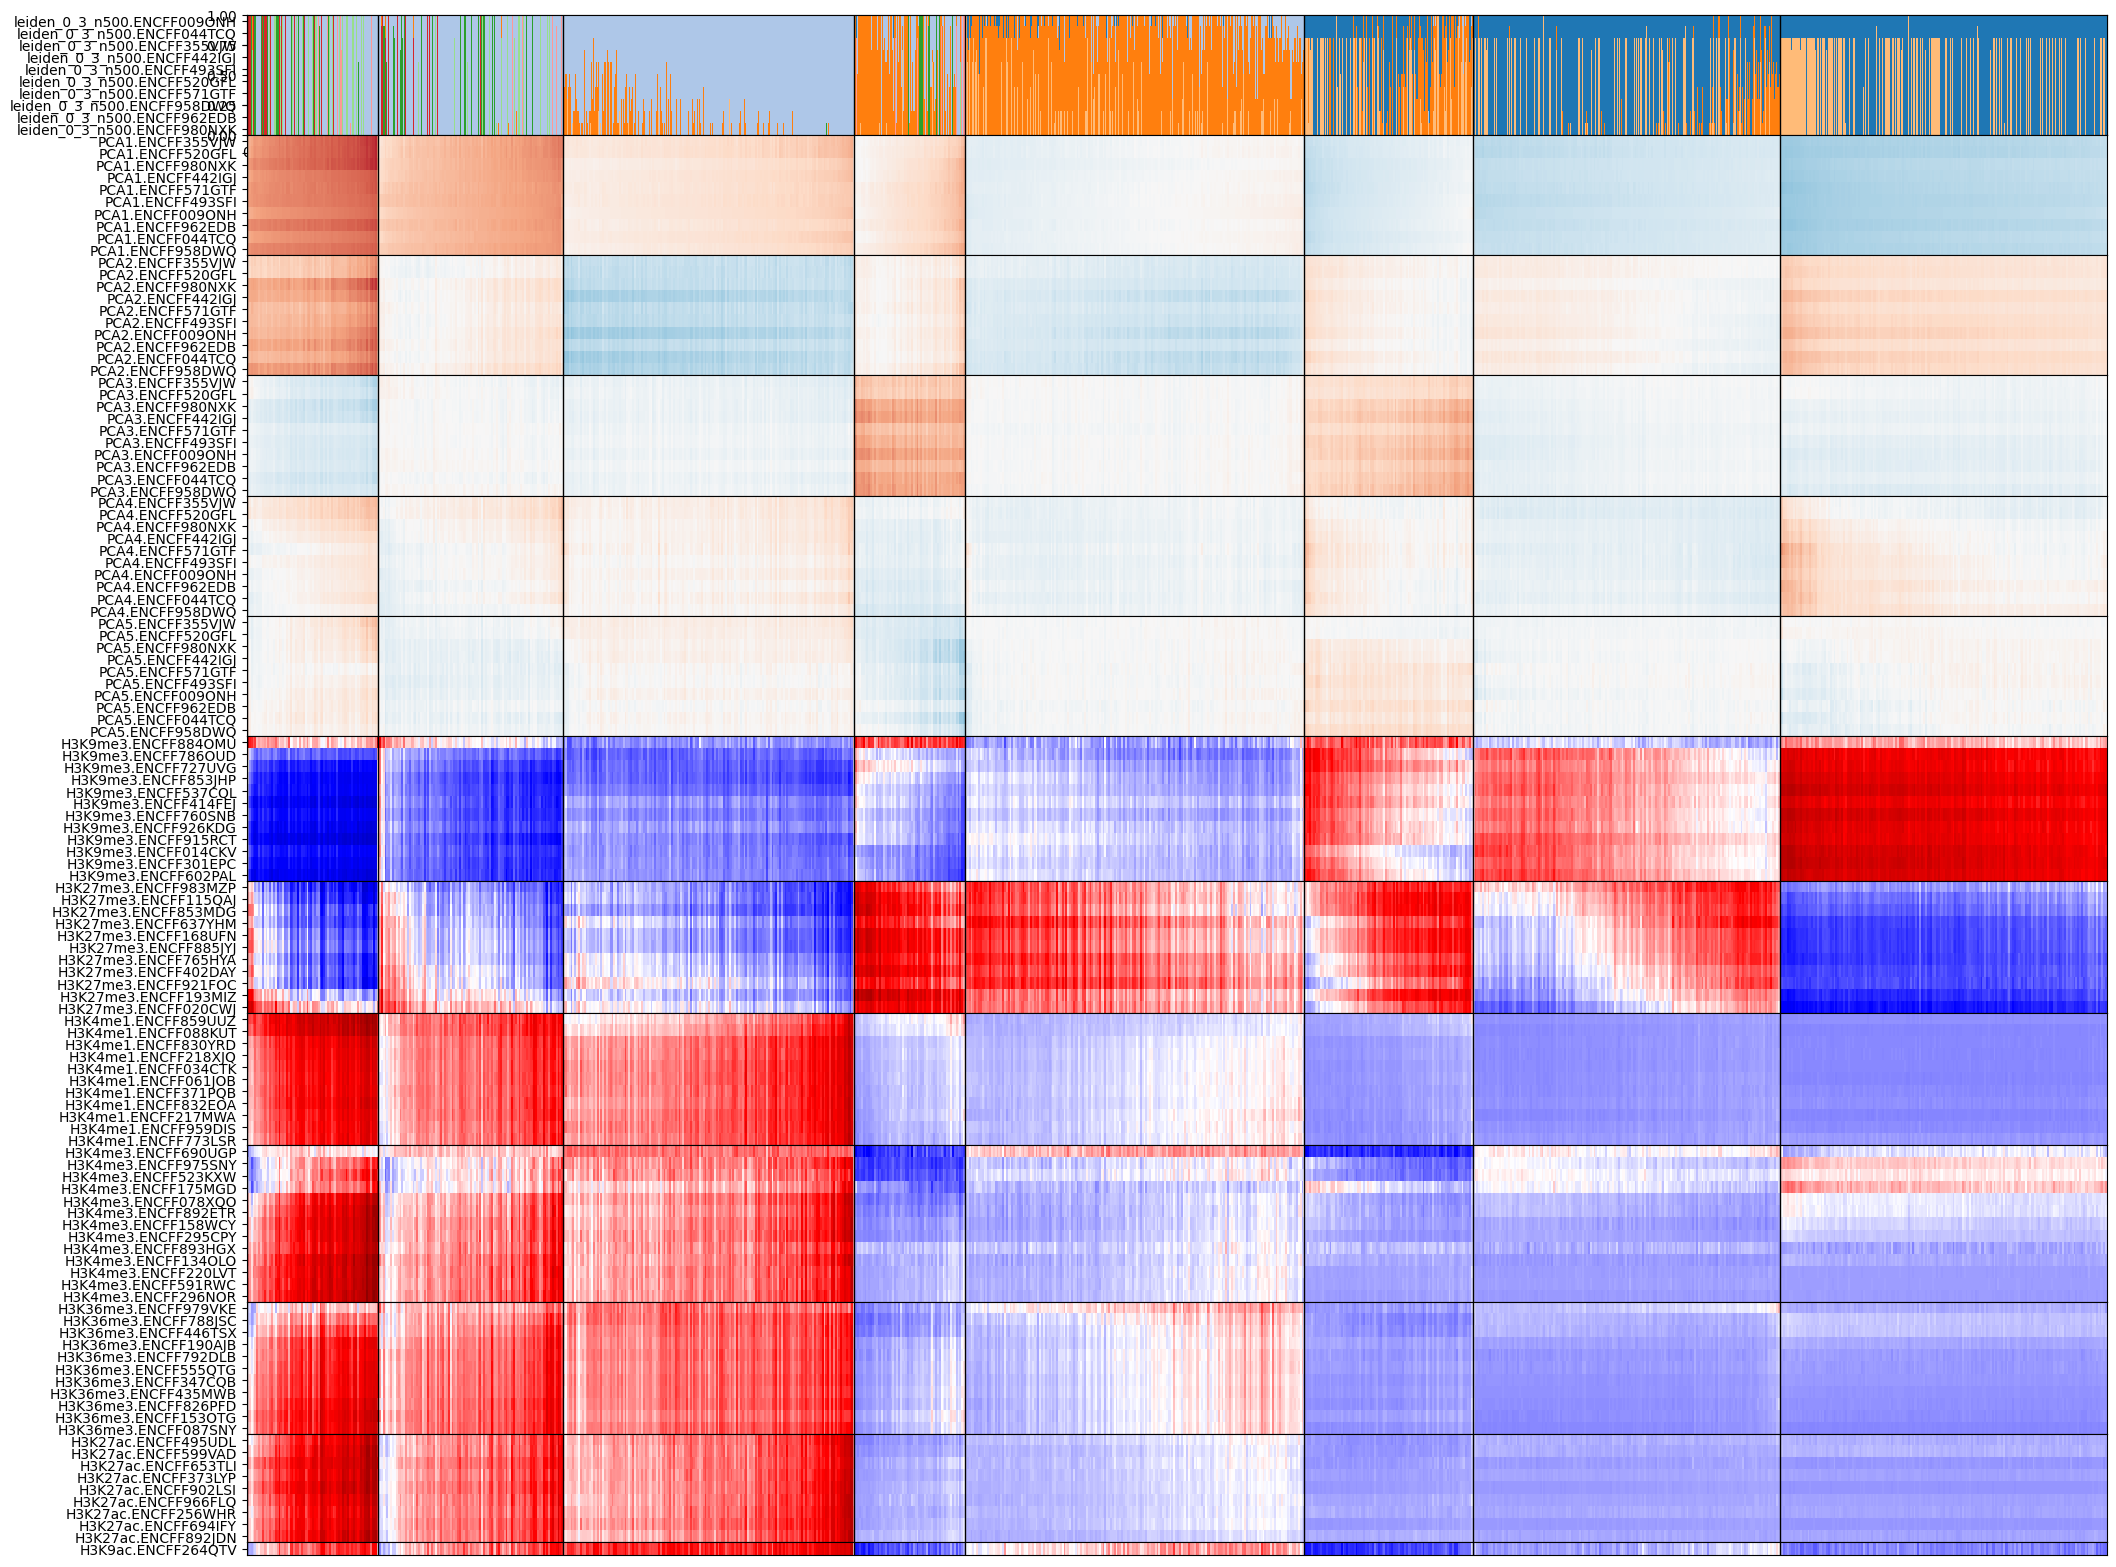

In [16]:
final_df["cluster"] = final_df["kmeans_8"].astype(int).map(cluster_to_rank)
new_trackconfs["IPG"] = trackconfs["IPG"]

fig = clustermap(
    final_df,
    group_by="cluster",
    sort_by=["PCA1.ENCFF009ONH"],
    layout=layout,
    trackconfs=new_trackconfs,
    filename="ordered-trajectory-heatmap.pdf",
)